**Definição das bibliotecas**

In [1]:
import nltk
import random
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from statistics import mode
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from scipy.stats import wilcoxon, friedmanchisquare
import re
import pandas as pd
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from collections import Counter
from matplotlib import pyplot as plt

**Inclusão da base de dados**

In [2]:
data=pd.read_csv('../input/dados/dados/train.tsv',delimiter='\t',encoding='utf-8')

data.head()

,Id,IdSentenca,Texto,Sentimento
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


**Pré processamento do Texto**
* A função a seguir realiza a limpeza das frases da coluna "Texto" para posterior vetorização (transformação das palavras em features)

In [3]:
def TextPreprocessing(sentence):
    
    #remoção de pontuação e caracteres especiais 
    cleaned = re.sub(r'[^\w\s]', '', sentence.lower())
    
    #remoção de números:
    cleaned = re.sub(r'\d+', '', cleaned)
    
    #remoção de stopwords:
    stop_words = list(set(stopwords.words('english')))
    stopped = [w for w in word_tokenize(cleaned) if not w in stop_words]
    
    no_stopwords = " ".join(stopped)
    
    return no_stopwords    

**Aplicando o pré-processamento do texto:**

In [4]:
data['Texto'] = data['Texto'].apply(lambda x: TextPreprocessing(x))

data.head()

,Id,IdSentenca,Texto,Sentimento
0,1,1,series escapades demonstrating adage good goos...,1
1,2,1,series escapades demonstrating adage good goose,2
2,3,1,series,2
3,4,1,,2
4,5,1,series,2


**Remoção das linhas vazias após o Pré-processamento do texto: **

In [5]:
indexs =  data[data['Texto'] == '' ].index
data.drop(indexs , inplace=True)
data.head()

,Id,IdSentenca,Texto,Sentimento
0,1,1,series escapades demonstrating adage good goos...,1
1,2,1,series escapades demonstrating adage good goose,2
2,3,1,series,2
4,5,1,series,2
5,6,1,escapades demonstrating adage good goose,2


**Visualização dos dados: gráfico de frequência das palavras**

In [6]:
def WordFreq(data):
    
    tags = ["negativos", "um pouco negativos", "neutros", "um pouco positivos", "positivos"]
    for sentimento in np.unique(data['Sentimento'].values):
        
        print ("Palavras mais comuns dos textos",tags[sentimento],":")
        data_sent = data[data['Sentimento'] == sentimento]
        all_words = " ".join(data_sent["Texto"].values)
        fdist = Counter(all_words.split()) 
        most_occur = dict(fdist.most_common(30))
        words = list(most_occur.keys())
        freqs = list(most_occur.values())
        
        colors = lambda i: list(map(lambda cor: "#" + "%06x" % random.randint(0, 0xFFFFFF),range(30)))
        plt.figure(figsize=(12,8))
        plt.bar(words, freqs, color=colors(30))
        plt.xticks(rotation=50)
        plt.xlabel("Palavras")
        plt.ylabel("Frequência")
        plt.show()
        

Palavras mais comuns dos textos negativos :


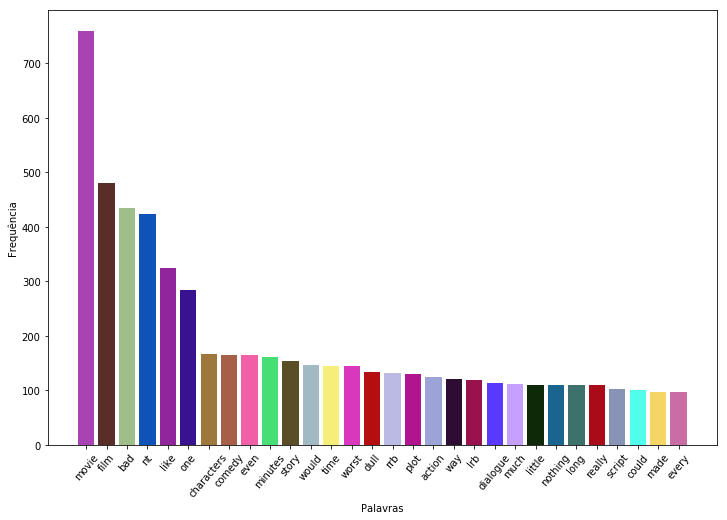

Palavras mais comuns dos textos um pouco negativos :


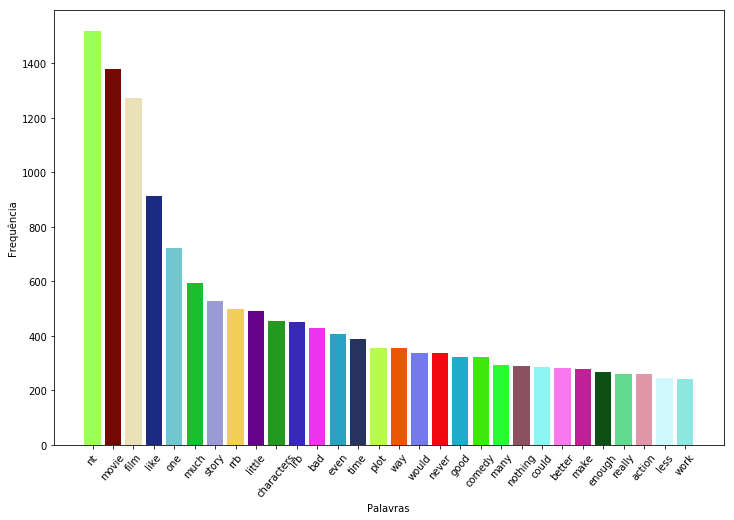

Palavras mais comuns dos textos neutros :


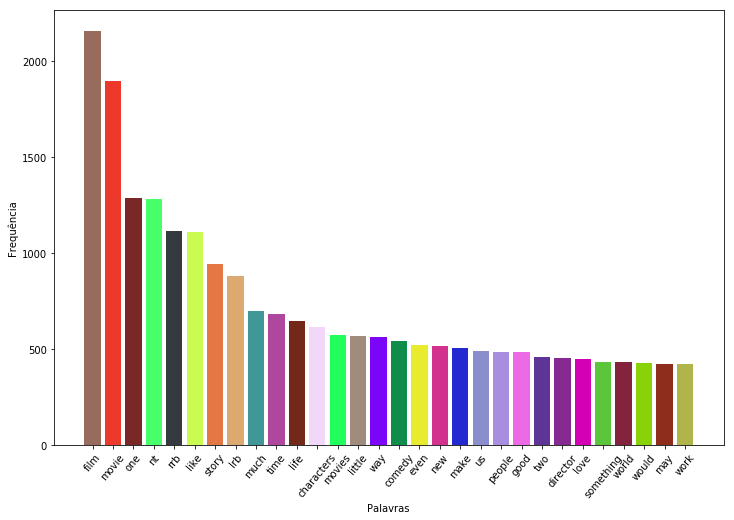

Palavras mais comuns dos textos um pouco positivos :


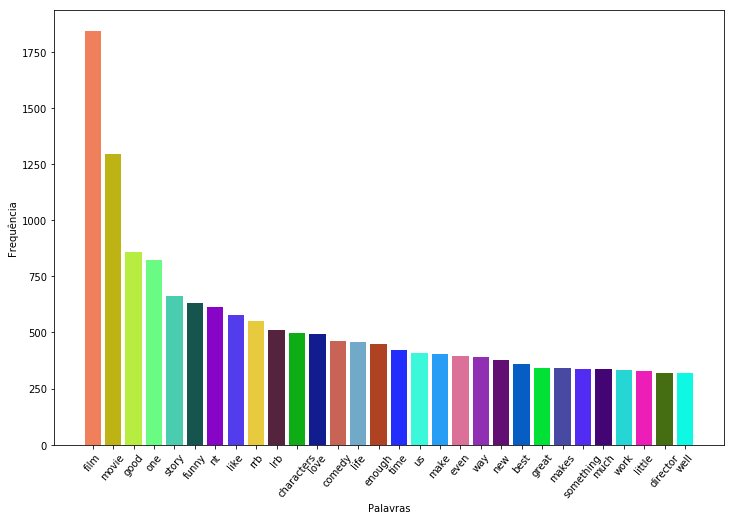

Palavras mais comuns dos textos positivos :


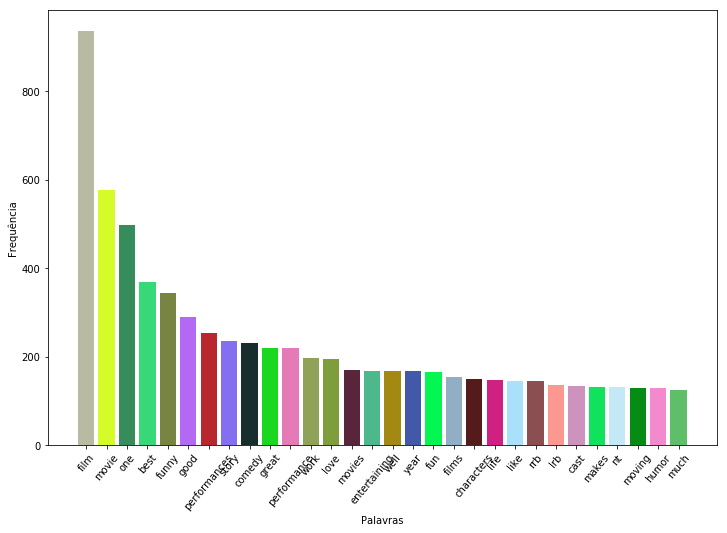

In [7]:
WordFreq(data)

**Vetorização dos dados para classificação**
* A função a seguir realiza a vetorização das palavras utilizando o conceito de BagOfWords
* Método de vetorização considerado: TfidfVectorizer

In [8]:
def Vectorization (data, max_feats):
    
    features = TfidfVectorizer(max_features = max_feats)
    features.fit(data)
    X = features.transform(data).toarray()

    return X

**A quantidade de palavras da *Bag of words* será de cerca de 40% das palavras mais frequentes de todas as frases do dataset. **

In [9]:
#Contagem de palavras distintas de todo dataset:
all_words = " ".join(data["Texto"].values)
words = [w for w in word_tokenize(all_words)]
diferent_words = len(set(words))
print(diferent_words)

16078


In [10]:
X = Vectorization (data["Texto"].values, int(0.4*diferent_words))
print(X.shape)
print(X)

(154652, 6431)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


**Divisão em dados de teste e treinamento**

In [11]:
def TrainTest(X, Y):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.20)
    return [X_train, X_test, y_train, y_test]

**Classificadores utilizados: SVM, Regressão Linear e NaiveBayes**

In [12]:
def SVM_clf(X_train, X_test, y_train):
        
    model = LinearSVC()
    model.fit(X_train, y_train)
    return model.predict(X_test)

def Regression(X_train, X_test, y_train):
        
    model = LogisticRegression()
    model.fit(X_train, y_train)
    return model.predict(X_test)

def Bayes(X_train, X_test, y_train):
        
    model = MultinomialNB()
    model.fit(X_train, y_train)
    return model.predict(X_test)

**Aplicação dos modelos de classificadores utilizados**

In [13]:
Y = data["Sentimento"].values

train_test = TrainTest(X, Y)

In [14]:
svm_pred = SVM_clf(train_test[0], train_test[1], train_test[2])
print("Acurácia do classificador SVM:", accuracy_score(svm_pred, train_test[3]) )

Acurácia do classificador SVM: 0.6195402670460056


In [15]:
lr_pred = Regression(train_test[0], train_test[1], train_test[2])
print("Acurácia do classificador de Regressão Linear:", accuracy_score(lr_pred, train_test[3]) )


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Acurácia do classificador de Regressão Linear: 0.610972810449064


In [16]:
bayes_pred = Bayes(train_test[0], train_test[1], train_test[2])
print("Acurácia do classificador de Bayes:", accuracy_score(bayes_pred, train_test[3]) )

Acurácia do classificador de Bayes: 0.5799359865507097


**Comparação entre os modelos a partir de validação cruzada estratificada 5 times x 10 folders**

In [17]:
Y = data["Sentimento"].values

rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=5)

scores_svm =[]
scores_lr = []
scores_bayes = []

for train_index, test_index in rskf.split(X, Y):
    X_train, X_test = data[train_index], data[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    svm_pred = SVM_clf(X_train,X_test, y_train)
    lr_pred = Regression(X_train,X_test, y_train)
    bayes_pred = Bayes(X_train,X_test, y_train)
    
    scores_svm.append(accuracy_score(svm_pred,y_test))
    scores_lr.append(accuracy_score(lr_pred,y_test))
    scores_bayes.append(accuracy_score(bayes_pred,y_test))

print("Acurácia do classificador SVM:",mean(scores_svm))
print("Acurácia do classificador de Regressão Linear:", mean(scores_lr))
print("Acurácia do classificador de Bayes:", mean(scores_bayes))


KeyError: '[     0      1      2 ... 154649 154650 154651] not in index'

**Com os resultados da validação cruzada, os algoritmos são comparados a partir do teste de Friedman**

* A hipótese nula deste teste, Ho, indica que não há diferenças estatísticas entre os procedimentos utilizados, ou seja, atuando sob os dados em análise neste desafio, os 3 algoritmos apresentam mesmo desempenho e a escolha de um em detrimento dos demais é irrelevante, se Ho for aceita para um nível de significância aqui adotado como alfa = 5%
* A hipótese alternativa, H1, indica que os algoritmos apresentados apresentam, de fato, diferentes desempenhos. Pode-se realizar o pós teste de Nemenyi para verificar qual os 3 algoritmos apresenta o melhor desempenho, porém seus valores médios de acurácia já indicam isto.

In [18]:
friedman_test = friedmanchisquare(scores_svm,scores_lr, scores_bayes)

statistica, p_value = friedman_test

print('Estatísitca=%.3f, p=%.6f' % (statistica, p))

alfa = 0.05

if p_value > alpha:
        print('Não existe diferenças significativas entre os 3 métodos utilizados para um nível de significância de 5%')
else:
    print('Existe diferença de desempenho entre os 3 algoritimos utilizados')
        

ZeroDivisionError: float division by zero